### code to install python2.7 on ubuntu and enable pip2 installer

In [17]:
!sudo apt update
!sudo apt install python2

Hit:2 https://download.docker.com/linux/ubuntu jammy InRelease                 
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                     
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease    
Hit:1 https://apt.llvm.org/jammy llvm-toolchain-jammy-17 InRelease             
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease             
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease               
Hit:3 https://packagecloud.io/github/git-lfs/ubuntu jammy InRelease            
0% [Connected to ppa.launchpadcontent.net (185.125.190.52)]m               

Hit:8 https://ppa.launchpadcontent.net/git-core/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ondrej/apache2/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ondrej/nginx-mainline/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ondrej/php/ubuntu jammy InRelease
Reading package lists... Done                               
Building dependency tree... Done
Reading state information... Done
34 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python2 is already the newest version (2.7.18-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Enable pip2 installer

In [ ]:
!sudo add-apt-repository universe
!sudo apt update -y
!curl https://bootstrap.pypa.io/pip/2.7/get-pip.py --output get-pip.py
!sudo python2 get-pip.py
!pip2 --version

### Installing recommended libraries

In [1]:
# !pip2 install pandas
# !pip2 install matplotlib
# !pip2 install scipy
# !pip2 install tensorflow==1.0.0

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [6]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [7]:
dataset = read_data('temp.txt')
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

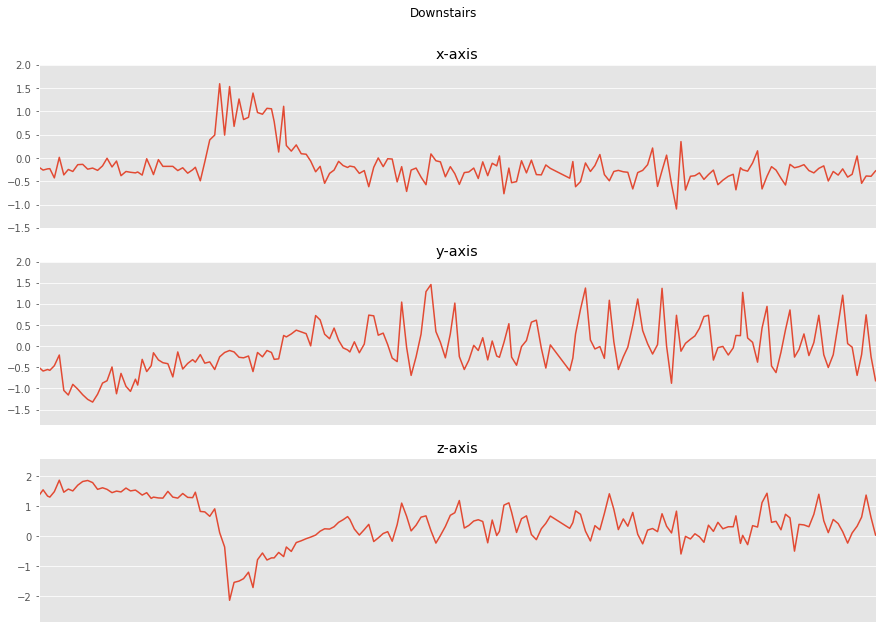

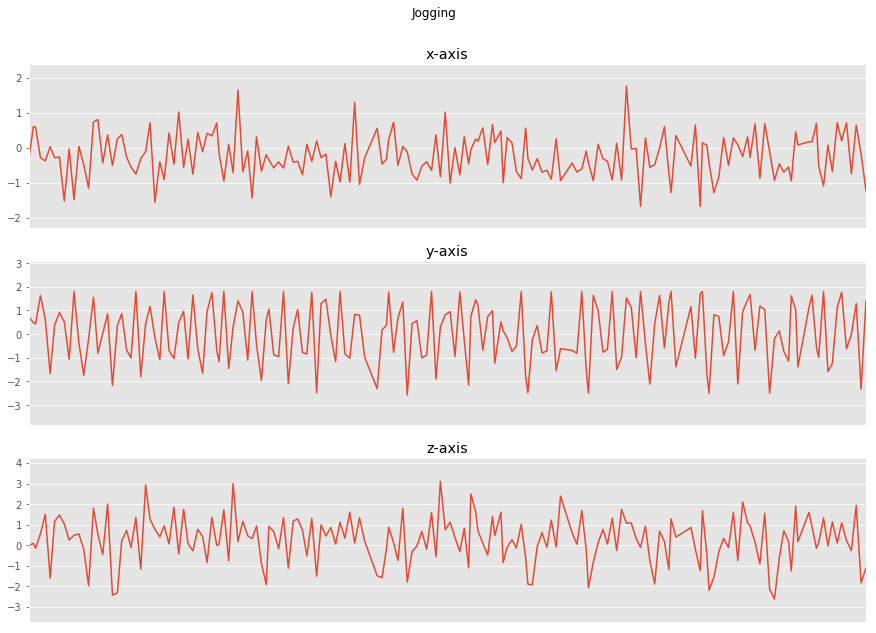

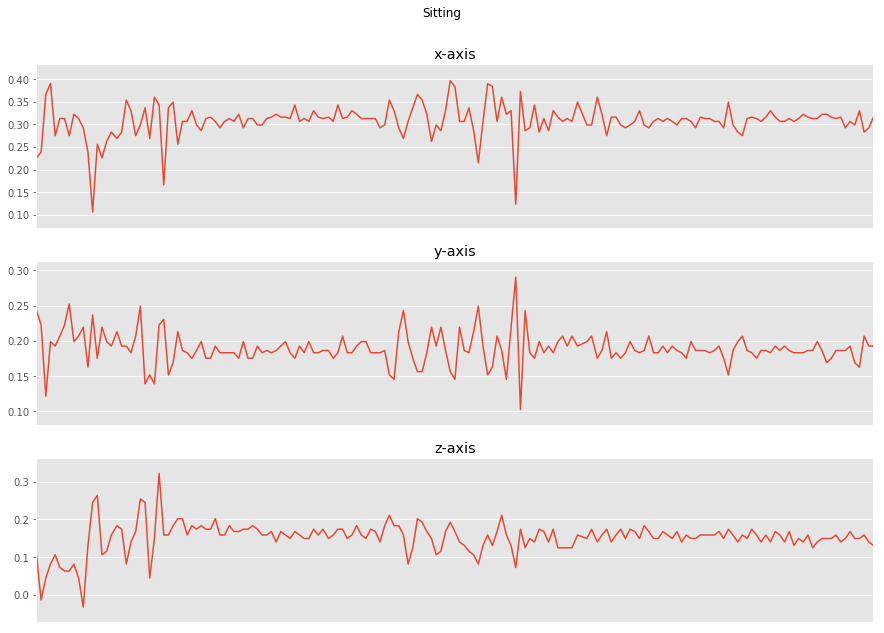

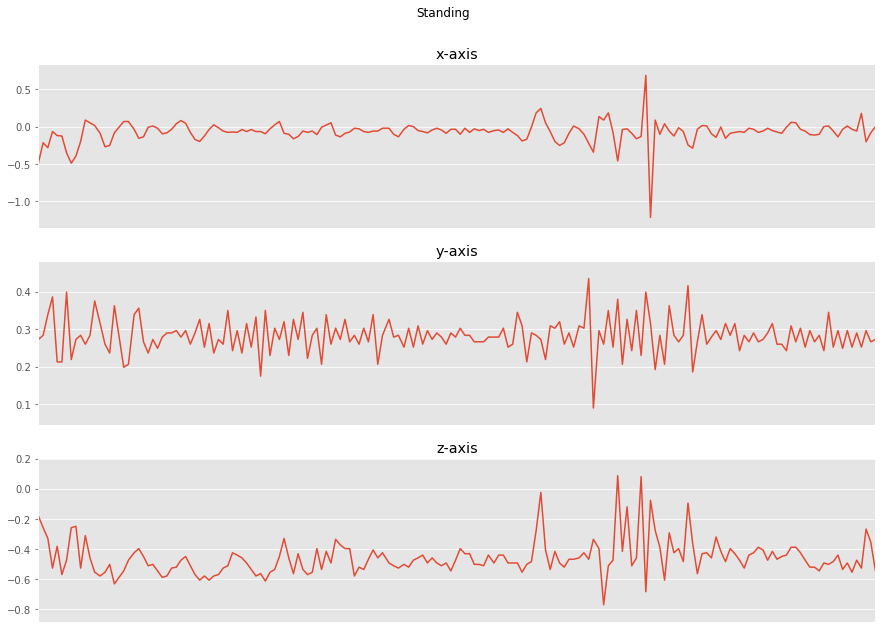

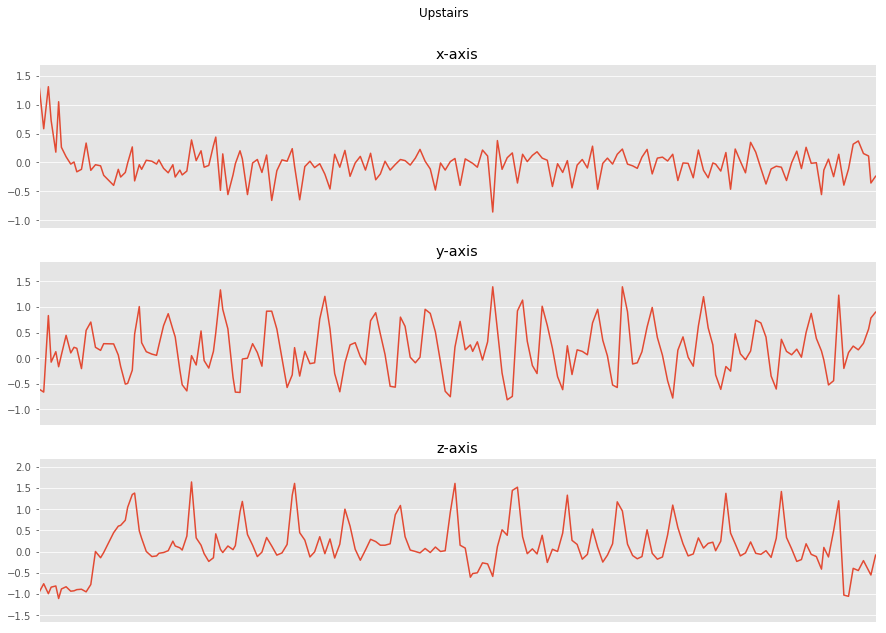

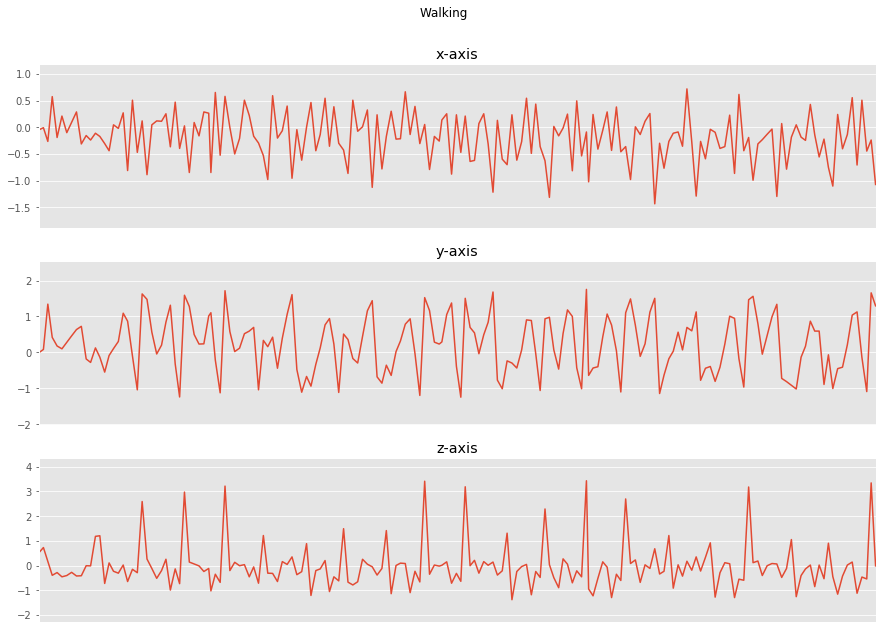

In [8]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)

In [9]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

/workspace/.pyenv_mirror/user/current/lib/python2.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [10]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [11]:
input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

In [12]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [13]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
cost_history = np.empty(shape=[1],dtype=float)

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

('Epoch: ', 0, ' Training Loss: ', 11.492891, ' Training Accuracy: ', 0.7139665)
('Epoch: ', 1, ' Training Loss: ', 7.8807745, ' Training Accuracy: ', 0.75502795)
('Epoch: ', 2, ' Training Loss: ', 6.162955, ' Training Accuracy: ', 0.8036313)
('Epoch: ', 3, ' Training Loss: ', 5.3542814, ' Training Accuracy: ', 0.82094973)
('Epoch: ', 4, ' Training Loss: ', 4.8749495, ' Training Accuracy: ', 0.8347765)
('Epoch: ', 5, ' Training Loss: ', 4.5506544, ' Training Accuracy: ', 0.8416201)
('Epoch: ', 6, ' Training Loss: ', 4.3086977, ' Training Accuracy: ', 0.84818435)
('Epoch: ', 7, ' Training Loss: ', 4.1039596, ' Training Accuracy: ', 0.8560056)
('Testing Accuracy:', 0.8469484)
